# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [12]:
# Repo paths (works even when notebook is in scripts/)
# We resolve the repo root by walking upward until we find the data folder.
from pathlib import Path


def find_repo_root(start=None):
    # Use current working directory by default to make notebook execution location-agnostic.
    start = Path.cwd() if start is None else Path(start)
    # Walk up the tree to find the project root that contains data/.
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    # Fallback to starting path if we cannot find the marker folder.
    return start


# Core paths used throughout the notebook so file IO is consistent.
ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
# Create plots directory so later saves do not fail.
PLOTS.mkdir(exist_ok=True)


In [13]:
# Data/ML stack used in the notebook.
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook

# Models and metrics (XGBoost and sklearn utilities).
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance

# Plotting and warnings control for cleaner notebook output.
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(
    'ignore',
    message=r'`sklearn\\.utils\\.parallel\\.delayed` should be used with `sklearn\\.utils\\.parallel\\.Parallel`',
    category=UserWarning,
)


In [14]:
# Re-establish repo paths so this cell can run independently.
from pathlib import Path
from typing import Optional


def find_repo_root(start: Optional[Path] = None) -> Path:
    # Resolve to an absolute path and walk upward to find the data/ folder.
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    # Fallback to the current path if the marker folder is missing.
    return p


# Canonical project paths used for input/output.
ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)


def resolve_input(filename: str) -> Path:
    # Prefer data/raw, then data/processed, then repo root for backward compatibility.
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    # Raise a helpful error if we cannot find the file anywhere expected.
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [15]:
# Load prebuilt master data.
master_path = resolve_input("master.csv")
# Parse timestamps and index the dataframe for time series operations.
df = pd.read_csv(master_path, parse_dates=["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")
print("Loaded", master_path, "with", len(df), "rows")


Loaded C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master.csv with 16682 rows


In [16]:
# Build ds with anchor intervals + interval-aggregated features (t0 -> t1)
# Real-life intent:
# - At time t0 (current pH/EC), you also have a climate forecast over (t0, t1]
#   and a planned irrigation/fert schedule over (t0, t1].
# - So we summarize the *interval inputs* between samples and learn to predict the next sample.

# Anchor rows are timestamps where both pH and EC exist; these define our t0 points.
anchors = df[df['ph'].notna() & df['ec_ms'].notna()].copy()
# t1 and next-observation deltas are derived by shifting the time series.
anchors['t1'] = anchors.index.to_series().shift(-1)
anchors['ph1'] = anchors['ph'].shift(-1)
anchors['ec1'] = anchors['ec_ms'].shift(-1)
# Gap length and target deltas are what we ultimately model.
anchors['gap_hours'] = (anchors['t1'] - anchors.index.to_series()).dt.total_seconds() / 3600
anchors['dph'] = anchors['ph1'] - anchors['ph']
anchors['dec'] = anchors['ec1'] - anchors['ec_ms']
# Drop any incomplete intervals caused by the shift.
anchors = anchors.dropna(subset=['t1','ph1','ec1','dph','dec'])


def build_interval_features(master: pd.DataFrame, intervals: pd.DataFrame) -> pd.DataFrame:
    # Build one feature row per interval (t0->t1) using aggregate inputs over the interval.
    rows = []
    start_time = master.index.min()


    def get_fert_any(frame: pd.DataFrame) -> pd.Series:
        # Normalize fertilization flags into a single binary series.
        if 'fertilization_flag' in frame.columns:
            return pd.to_numeric(frame['fertilization_flag'], errors='coerce').fillna(0)
        has_a = 'fertilization_type_a_flag' in frame.columns
        has_b = 'fertilization_type_b_flag' in frame.columns
        if has_a or has_b:
            fert_a = pd.to_numeric(frame['fertilization_type_a_flag'], errors='coerce').fillna(0) if has_a else 0
            fert_b = pd.to_numeric(frame['fertilization_type_b_flag'], errors='coerce').fillna(0) if has_b else 0
            if has_a and has_b:
                return ((fert_a > 0) | (fert_b > 0)).astype(int)
            if has_a:
                return (fert_a > 0).astype(int)
            return (fert_b > 0).astype(int)
        return pd.Series(0, index=frame.index)

    for t0, row in intervals.iterrows():
        # Slice the master data for the interval to compute aggregates.
        t1 = row['t1']
        seg = master.loc[t0:t1]
        feats: Dict[str, Any] = {}

        # Current observed rootzone state (t0).
        feats['ph0'] = float(row['ph'])
        feats['ec0'] = float(row['ec_ms'])
        feats['gap_hours'] = float(row['gap_hours'])

        # Days since start provides a slow trend proxy (developmental stage).
        if 'days_after_planting' in seg.columns:
            dap = pd.to_numeric(seg['days_after_planting'], errors='coerce')
            if dap.notna().any():
                feats['days_since_start'] = float(dap.dropna().iloc[0])
            else:
                feats['days_since_start'] = (t0 - start_time).total_seconds() / 86400
        else:
            feats['days_since_start'] = (t0 - start_time).total_seconds() / 86400

        # Fert dose aggregates (mg) from master columns.
        dose_cols = [
            'Ammonium Nitrate [mg] -NH4NO3',
            'Monopotassium Phosphate[mg] -KH2PO4',
            'Potassium Chloride[mg] - KCL',
            'Phosphoric acid[mg]-H3PO4',
            'Kortin [mg]',
            'Gypsum - CaSO4*2H2O [mg]',
        ]
        avail_dose_cols = [c for c in dose_cols if c in master.columns]
        if avail_dose_cols:
            dose_seg = seg[avail_dose_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
            feats['fert_dose_sum_t0_t1'] = float(dose_seg.sum().sum())
            dose_hist = master.loc[:t1, avail_dose_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
            for win_hours, win_name in [(8, '8h'), (16, '16h'), (24, '24h')]:
                win_start = t1 - timedelta(hours=win_hours)
                feats[f'fert_dose_sum_{win_name}'] = float(dose_hist.loc[win_start:t1].sum().sum())
        else:
            feats['fert_dose_sum_t0_t1'] = 0.0
            feats['fert_dose_sum_8h'] = 0.0
            feats['fert_dose_sum_16h'] = 0.0
            feats['fert_dose_sum_24h'] = 0.0


        # Irrigation sums in rolling windows to capture effects over time.
        if 'irrigation_ml_current' in master.columns:
            irr_hist = pd.to_numeric(master.loc[:t1, 'irrigation_ml_current'], errors='coerce').fillna(0.0)
            for win_hours, win_name in [(8, '8h'), (16, '16h'), (24, '24h')]:
                win_start = t1 - timedelta(hours=win_hours)
                feats[f'irr_ml_sum_{win_name}'] = float(irr_hist.loc[win_start:t1].sum())
        else:
            feats['irr_ml_sum_8h'] = 0.0
            feats['irr_ml_sum_16h'] = 0.0
            feats['irr_ml_sum_24h'] = 0.0


        # Hours since last events at t1 (can be outside interval).
        if 'irrigation_ml_current' in master.columns:
            irr_hist = pd.to_numeric(master.loc[:t1, 'irrigation_ml_current'], errors='coerce').fillna(0.0)
            last_irr_idx_all = irr_hist[irr_hist > 0].index.max() if (irr_hist > 0).any() else None
            feats['hrs_since_last_irrig_t1'] = (t1 - last_irr_idx_all).total_seconds() / 3600 if last_irr_idx_all is not None else np.nan
        else:
            feats['hrs_since_last_irrig_t1'] = np.nan

        if ('fertilization_flag' in master.columns or
            'fertilization_type_a_flag' in master.columns or
            'fertilization_type_b_flag' in master.columns):
            fert_hist = get_fert_any(master.loc[:t1])
            last_fert_idx_all = fert_hist[fert_hist > 0].index.max() if (fert_hist > 0).any() else None
            hours_since_last_fert_t1 = (t1 - last_fert_idx_all).total_seconds() / 3600 if last_fert_idx_all is not None else np.nan
            feats['hours_since_last_fert_t1'] = hours_since_last_fert_t1

            fert_hist_t0 = get_fert_any(master.loc[:t0])
            last_fert_idx_t0 = fert_hist_t0[fert_hist_t0 > 0].index.max() if (fert_hist_t0 > 0).any() else None
            feats['hours_since_last_fert_t0'] = (t0 - last_fert_idx_t0).total_seconds() / 3600 if last_fert_idx_t0 is not None else np.nan

            for win_hours, win_name in [(1, '1h'), (4, '4h'), (8, '8h'), (24, '24h')]:
                win_start = t1 - timedelta(hours=win_hours)
                fert_win = get_fert_any(master.loc[win_start:t1])
                feats[f'fert_event_count_{win_name}'] = float(fert_win.sum())
        else:
            feats['hours_since_last_fert_t1'] = np.nan
            feats['hours_since_last_fert_t0'] = np.nan
            for win_name in ['1h', '4h', '8h', '24h']:
                feats[f'fert_event_count_{win_name}'] = 0.0


        # Climate aggregates (only those used).
        if 'internal_air_temp_c' in seg.columns:
            s = pd.to_numeric(seg['internal_air_temp_c'], errors='coerce')
            feats['internal_air_temp_c_mean_t0_t1'] = float(s.mean())
            feats['internal_air_temp_c_max_t0_t1'] = float(s.max())
            if len(s) >= 1:
                feats['internal_air_temp_c_delta_t0_t1'] = float(s.iloc[-1] - s.iloc[0])
        if 'internal_rh_%' in seg.columns:
            s = pd.to_numeric(seg['internal_rh_%'], errors='coerce')
            feats['internal_rh_%_mean_t0_t1'] = float(s.mean())
        if 'internal_radiation' in seg.columns:
            s = pd.to_numeric(seg['internal_radiation'], errors='coerce')
            feats['internal_radiation_sum_t0_t1'] = float(s.sum())
        if 'ET0' in seg.columns:
            s = pd.to_numeric(seg['ET0'], errors='coerce')
            feats['ET0_sum_t0_t1'] = float(s.sum())
        if 'soil_temp_pred' in seg.columns:
            st = pd.to_numeric(seg['soil_temp_pred'], errors='coerce')
            feats['soil_temp_mean_t0_t1'] = float(st.mean())
        if 'canopy_cover' in seg.columns:
            cc = pd.to_numeric(seg['canopy_cover'], errors='coerce')
            feats['canopy_mean_t0_t1'] = float(cc.mean())
       
        # Derived features.
        if 'ET0_sum_t0_t1' in feats and feats['gap_hours'] > 0:
            feats['ET0_sum_per_hour'] = feats['ET0_sum_t0_t1'] / feats['gap_hours']
        elif 'ET0_sum_t0_t1' in feats:
            feats['ET0_sum_per_hour'] = np.nan
        feats['soil_temp_mean'] = feats.get('soil_temp_mean_t0_t1', np.nan)

        # Append the interval feature row.
        rows.append(feats)

    return pd.DataFrame(rows, index=intervals.index)


# Build interval-level dataset and merge with targets.
interval_feats = build_interval_features(df, anchors)
ds = pd.concat([anchors[['t1', 'dph', 'dec']], interval_feats], axis=1)


# Drop any rows with NaNs in features.
feature_cols_tmp = [c for c in ds.columns if c not in ['t1', 'dph', 'dec']]
ds = ds.dropna(subset=feature_cols_tmp)
print('Built ds with intervals:', len(ds), '| features:', len(feature_cols_tmp))
used_cols = ['t1','dph','dec'] + feature_cols_tmp
used_cols = [c for c in used_cols if c in ds.columns]
display(ds[used_cols])


Built ds with intervals: 108 | features: 28


,t1,dph,dec,ph0,ec0,gap_hours,days_since_start,fert_dose_sum_t0_t1,fert_dose_sum_8h,fert_dose_sum_16h,fert_dose_sum_24h,irr_ml_sum_8h,irr_ml_sum_16h,irr_ml_sum_24h,hrs_since_last_irrig_t1,hours_since_last_fert_t1,hours_since_last_fert_t0,fert_event_count_1h,fert_event_count_4h,fert_event_count_8h,fert_event_count_24h,internal_air_temp_c_mean_t0_t1,internal_air_temp_c_max_t0_t1,internal_air_temp_c_delta_t0_t1,internal_rh_%_mean_t0_t1,internal_radiation_sum_t0_t1,ET0_sum_t0_t1,soil_temp_mean_t0_t1,canopy_mean_t0_t1,ET0_sum_per_hour,soil_temp_mean
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-12 11:50:00,2025-06-29 12:10:00,1.49,0.00000,6.71,0.29000,408.333333,14.0,1342.000000,0.000000,0.000000,0.000000,266.666667,266.666667,533.333333,2.166667,72.666667,42.833333,0.0,0.0,0.0,0.0,27.857455,35.250526,1.571820,72.856957,510277.056695,435.870675,27.536951,0.097777,1.067438,27.536951
2025-06-29 12:10:00,2025-07-07 11:00:00,-1.09,0.07100,8.20,0.29000,190.833333,31.0,1372.000000,335.500000,335.500000,335.500000,100.000000,100.000000,200.000000,0.000000,0.000000,72.666667,1.0,1.0,1.0,1.0,28.527284,36.121230,-0.559626,71.290854,232427.866803,196.383575,29.250217,0.067923,1.029084,29.250217
2025-07-07 11:00:00,2025-07-16 14:00:00,-0.36,0.02600,7.11,0.36100,219.000000,39.0,1993.132874,325.566437,325.566437,651.132874,600.000000,600.000000,833.333333,0.500000,5.000000,0.000000,0.0,0.0,1.0,2.0,28.633594,35.069870,-0.300289,72.703767,279294.147262,232.060792,29.255402,0.086382,1.059638,29.255402
2025-07-16 14:00:00,2025-07-20 12:50:00,0.11,0.13300,6.75,0.38700,94.833333,48.0,651.132874,325.566437,325.566437,325.566437,366.666667,366.666667,633.333333,0.000000,0.000000,5.000000,1.0,1.0,1.0,1.0,29.146089,35.781082,-0.119011,69.701815,122444.152735,97.869665,30.071080,0.144799,1.032018,30.071080
2025-07-20 12:50:00,2025-07-23 11:30:00,-0.05,-0.19500,6.86,0.52000,70.666667,52.0,976.699311,325.566437,325.566437,325.566437,366.666667,366.666667,633.333333,0.166667,0.166667,0.000000,1.0,1.0,1.0,1.0,29.097258,35.403713,1.091720,72.993200,87688.762784,70.207346,29.872846,0.192724,0.993500,29.872846
2025-07-23 11:30:00,2025-07-23 17:30:00,1.33,0.03550,6.81,0.32500,6.000000,55.0,0.000000,325.566437,325.566437,325.566437,600.000000,733.333333,733.333333,1.500000,6.166667,0.166667,0.0,0.0,1.0,1.0,33.372550,34.947400,-3.719402,65.577722,16991.118968,14.462700,35.997604,0.216038,2.410450,35.997604
2025-07-23 17:30:00,2025-07-24 11:00:00,1.35,0.22160,8.14,0.36050,17.500000,55.0,0.000000,0.000000,0.000000,325.566437,266.666667,266.666667,733.333333,1.000000,23.666667,6.166667,0.0,0.0,0.0,1.0,27.726608,34.616062,3.519180,76.122701,10693.040786,9.424428,28.422339,0.226578,0.538539,28.422339
2025-07-24 11:00:00,2025-07-24 15:10:00,-0.27,-0.03180,9.49,0.58210,4.166667,56.0,325.566437,325.566437,325.566437,325.566437,366.666667,500.000000,633.333333,0.000000,0.000000,23.666667,1.0,1.0,1.0,1.0,34.358087,34.682810,-0.771358,57.977442,16975.168690,14.005906,36.781501,0.232713,3.361418,36.781501
2025-07-24 15:10:00,2025-07-27 14:10:00,-1.57,-0.17320,9.22,0.55030,71.000000,56.0,651.132874,325.566437,325.566437,325.566437,500.000000,500.000000,633.333333,1.166667,3.166667,0.000000,0.0,1.0,1.0,1.0,29.274626,34.993110,0.541450,73.504242,83823.841676,69.818413,30.523958,0.261059,0.983358,30.523958


Master data rows: 16682 cols: 19
Date range: 2025-05-29 01:00:00 -> 2025-09-21 21:10:00


,missing_frac
ec_ms,0.993466
ph,0.993466
soil_temp_pred,0.000540
internal_rh_%,0.000000
internal_air_temp_c,0.000000
ET0,0.000000
internal_radiation,0.000000
fertilization_type_a_flag,0.000000
fertilization_flag,0.000000
irrigation_ml_current,0.000000


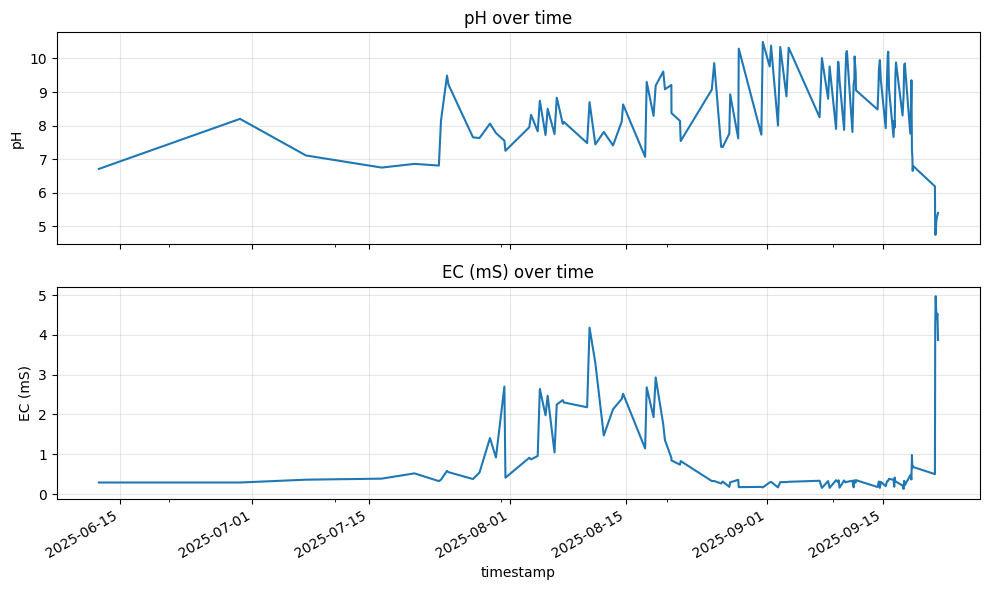

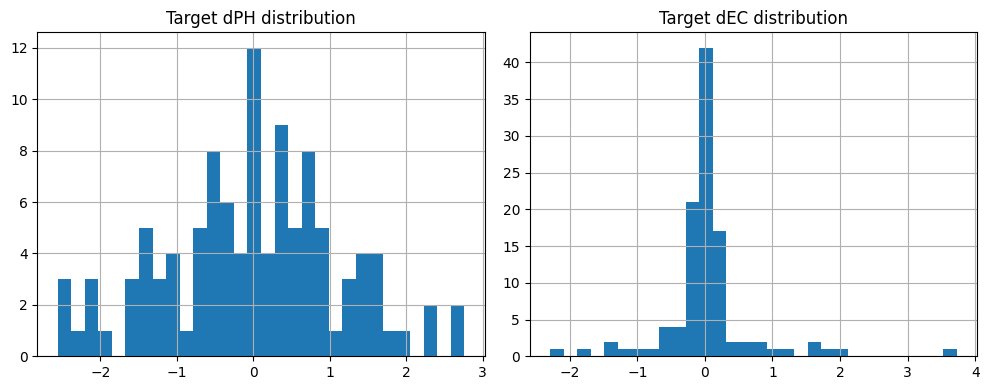

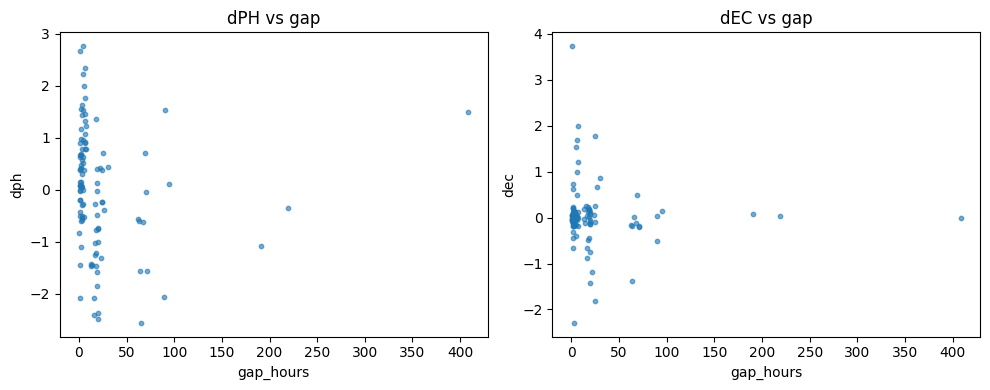

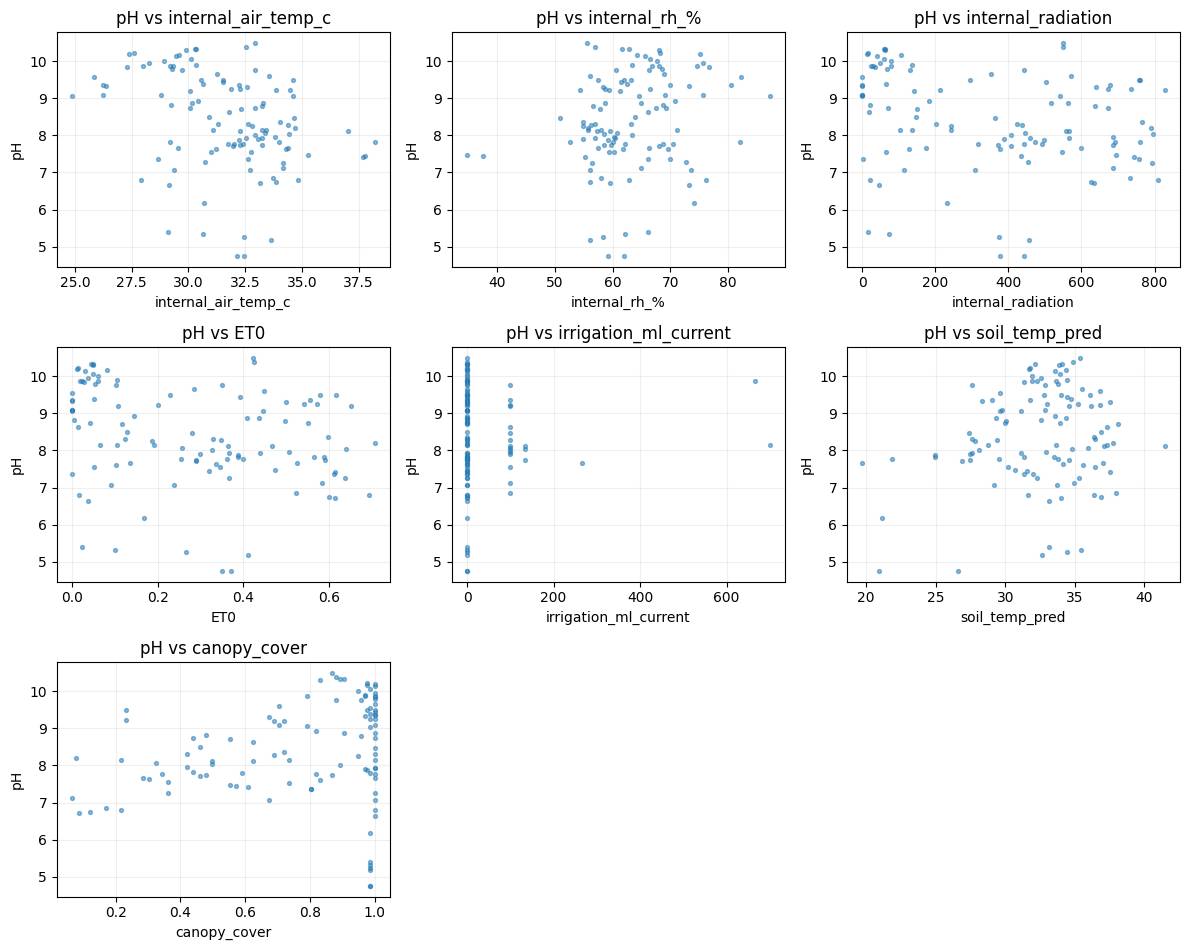

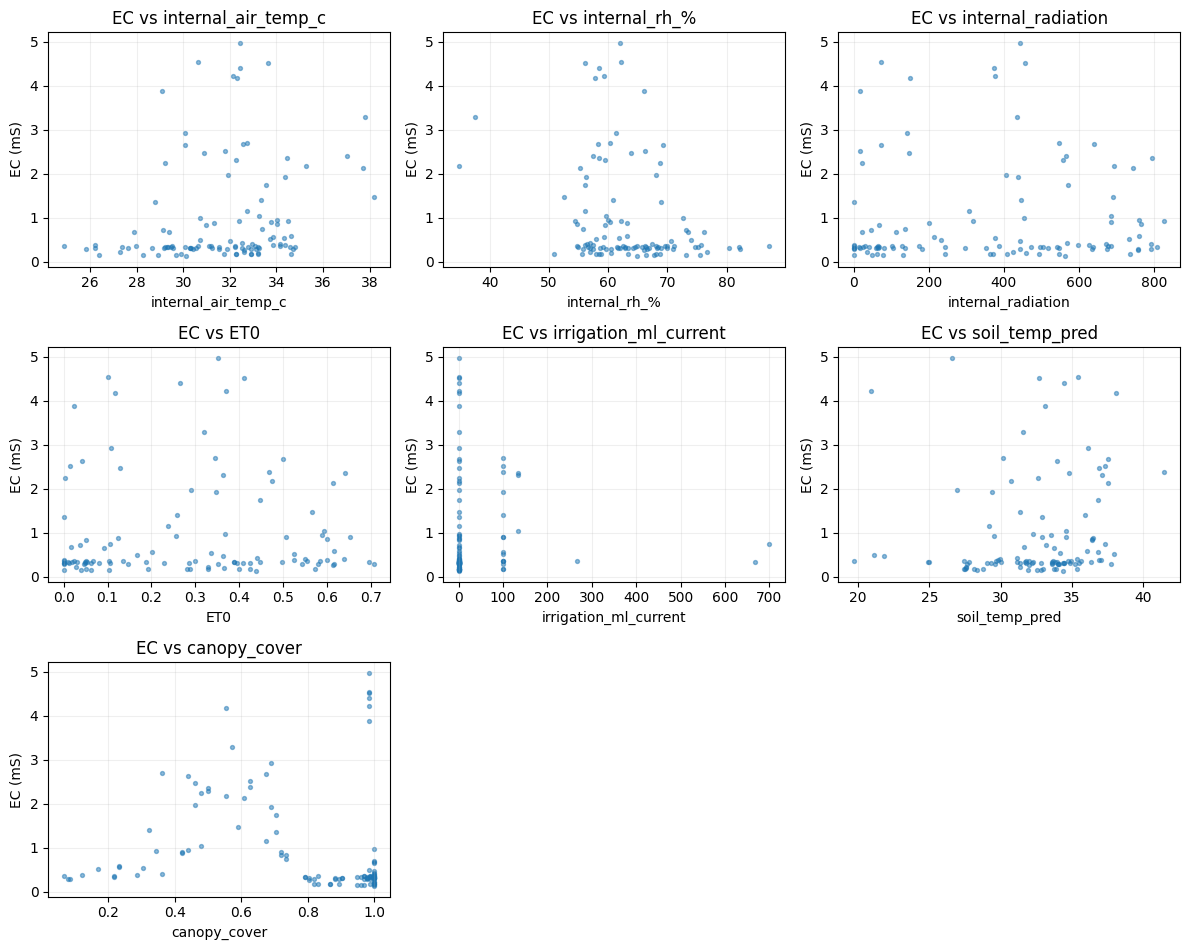

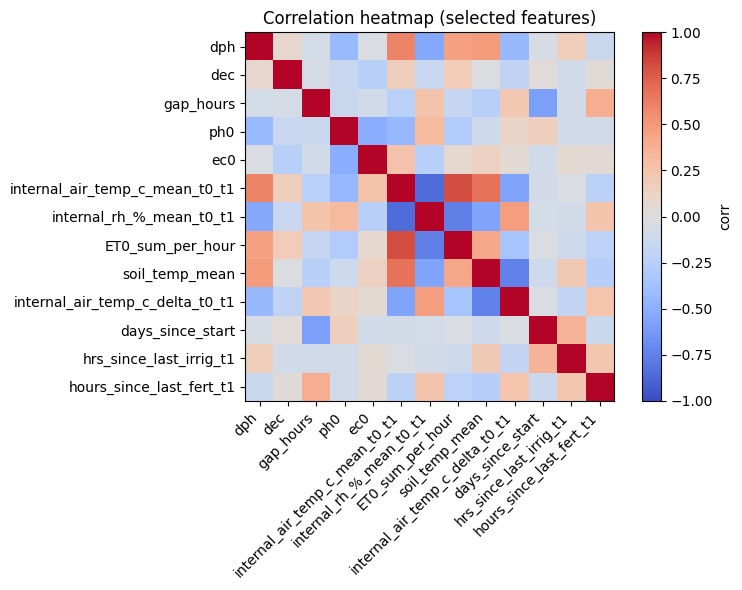

In [17]:
# Quick visuals before modeling.

# Basic dataset overview helps sanity check before training.
print('Master data rows:', len(df), 'cols:', df.shape[1])
print('Date range:', df.index.min(), '->', df.index.max())
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame('missing_frac').head(12))


# Time series for core targets (plot only non-null values).
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
if 'ph' in df.columns:
    df.loc[df['ph'].notna(), 'ph'].plot(ax=ax[0], title='pH over time')
    ax[0].set_ylabel('pH')
else:
    ax[0].set_title('pH over time (missing column)')
if 'ec_ms' in df.columns:
    df.loc[df['ec_ms'].notna(), 'ec_ms'].plot(ax=ax[1], title='EC (mS) over time')
    ax[1].set_ylabel('EC (mS)')
else:
    ax[1].set_title('EC (mS) over time (missing column)')
for a in ax: a.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


# Target distributions show how heavy-tailed or skewed the targets are.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'dph' in ds.columns:
    ds['dph'].hist(ax=ax[0], bins=30)
    ax[0].set_title('Target dPH distribution')
else:
    ax[0].set_title('Target dPH distribution (missing)')
if 'dec' in ds.columns:
    ds['dec'].hist(ax=ax[1], bins=30)
    ax[1].set_title('Target dEC distribution')
else:
    ax[1].set_title('Target dEC distribution (missing)')
plt.tight_layout(); plt.show()


# Gap vs targets to see if time gaps drive stronger changes.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'gap_hours' in ds.columns and 'dph' in ds.columns:
    ax[0].scatter(ds['gap_hours'], ds['dph'], s=10, alpha=0.6)
    ax[0].set_xlabel('gap_hours'); ax[0].set_ylabel('dph'); ax[0].set_title('dPH vs gap')
else:
    ax[0].set_title('dPH vs gap (missing)')
if 'gap_hours' in ds.columns and 'dec' in ds.columns:
    ax[1].scatter(ds['gap_hours'], ds['dec'], s=10, alpha=0.6)
    ax[1].set_xlabel('gap_hours'); ax[1].set_ylabel('dec'); ax[1].set_title('dEC vs gap')
else:
    ax[1].set_title('dEC vs gap (missing)')
plt.tight_layout(); plt.show()


# pH/EC vs selected input features (scatter).
scatter_feats = ['internal_air_temp_c', 'internal_rh_%', 'internal_radiation', 'ET0', 'irrigation_ml_current', 'soil_temp_pred', 'canopy_cover']
scatter_feats = [c for c in scatter_feats if c in df.columns]
if scatter_feats:
    n = len(scatter_feats)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = np.atleast_1d(axes).ravel()
    for i, feat in enumerate(scatter_feats):
        ax = axes[i]
        if 'ph' in df.columns:
            ax.scatter(df[feat], df['ph'], s=8, alpha=0.5)
            ax.set_ylabel('pH')
        ax.set_xlabel(feat)
        ax.set_title(f'pH vs {feat}')
        ax.grid(True, alpha=0.2)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = np.atleast_1d(axes).ravel()
    for i, feat in enumerate(scatter_feats):
        ax = axes[i]
        if 'ec_ms' in df.columns:
            ax.scatter(df[feat], df['ec_ms'], s=8, alpha=0.5)
            ax.set_ylabel('EC (mS)')
        ax.set_xlabel(feat)
        ax.set_title(f'EC vs {feat}')
        ax.grid(True, alpha=0.2)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


# Correlations for a small, interpretable subset.
corr_cols = ['dph','dec','gap_hours','ph0','ec0','internal_air_temp_c_mean_t0_t1','internal_rh_%_mean_t0_t1','ET0_sum_per_hour','soil_temp_mean','internal_air_temp_c_delta_t0_t1','days_since_start','irrig_to_gap_ratio','hrs_since_last_irrig_t1','hours_since_last_fert_t1']
corr_cols = [c for c in corr_cols if c in ds.columns]
if len(corr_cols) >= 2:
    corr = ds[corr_cols].corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation heatmap (selected features)')
    plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
    plt.yticks(range(len(corr_cols)), corr_cols)
    plt.colorbar(label='corr')
    plt.tight_layout()
    plt.show()


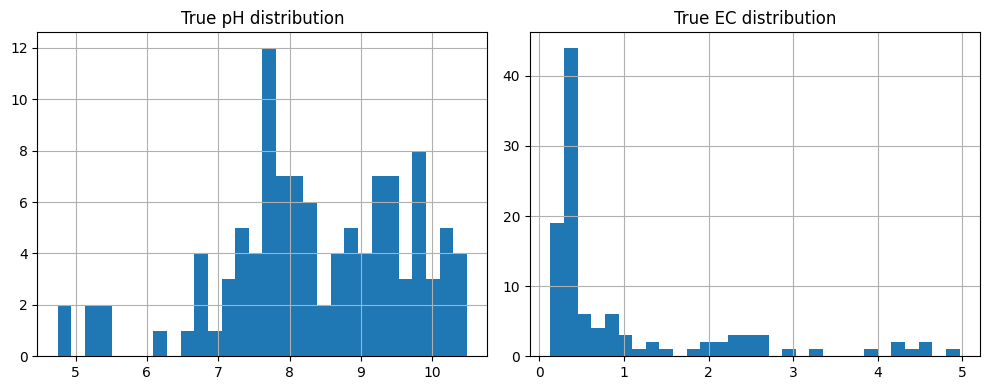

In [18]:
# Distributions of true pH/EC values (master series).
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'ph' in df.columns:
    df.loc[df['ph'].notna(), 'ph'].hist(ax=ax[0], bins=30)
    ax[0].set_title('True pH distribution')
else:
    ax[0].set_title('True pH distribution (missing)')
if 'ec_ms' in df.columns:
    df.loc[df['ec_ms'].notna(), 'ec_ms'].hist(ax=ax[1], bins=30)
    ax[1].set_title('True EC distribution')
else:
    ax[1].set_title('True EC distribution (missing)')
plt.tight_layout(); plt.show()


## Targets
This notebook predicts only pH/EC deltas (`dph`, `dec`). `soil_temp_pred` is used only as an input feature (context), not as a target.

In [19]:
# Walk-forward on ds using XGBOOST (separate pH/EC feature sets)
# This simulates forecasting each interval using only past data.


def select_features(cols, df, label):
    # Validate requested features and warn about any missing columns.
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"Skipping missing {label} features: {missing}")
    keep = [c for c in cols if c in df.columns]
    if len(keep) == 0:
        raise ValueError(f"No {label} features left after filtering.")
    return keep

# Temporarily exclude specific intervals (t0 timestamps).
exclude_t0 = [
    '2025-09-18 15:10:00',
    '2025-09-21 06:30:00',
    '2025-09-21 07:20:00',
    '2025-09-21 08:40:00',
    '2025-09-21 10:30:00',
    '2025-09-21 11:40:00',
    '2025-09-21 13:40:00',
]
exclude_t0 = pd.to_datetime(exclude_t0)
# Only drop if those indices exist (keeps code safe if dates change).
if len(exclude_t0) > 0:
    ds = ds.drop(index=[t for t in exclude_t0 if t in ds.index])

# Pruned feature sets based on current importances.
feature_cols_ph = [
    'ph0','internal_rh_%_mean_t0_t1',
    'fert_dose_sum_24h',
    'fert_dose_sum_16h',
    'fert_dose_sum_8h',
    'irr_ml_sum_8h',
    'irr_ml_sum_16h',
    'irr_ml_sum_24h',
    'ET0_sum_per_hour',
    'hours_since_last_fert_t1',
    'hrs_since_last_irrig_t1',
    'internal_air_temp_c_mean_t0_t1',
    'soil_temp_mean',
    'ec0','internal_air_temp_c_delta_t0_t1',
    'gap_hours',]

feature_cols_ec = [
    'ec0','soil_temp_mean',
    'ph0','ET0_sum_per_hour',
    'irr_ml_sum_24h',
    'internal_rh_%_mean_t0_t1',
    'fert_dose_sum_24h',
    'fert_dose_sum_16h',
    'fert_dose_sum_8h',
    'internal_air_temp_c_delta_t0_t1',
    'internal_air_temp_c_mean_t0_t1',
    'hours_since_last_fert_t1',
    'hrs_since_last_irrig_t1',
    'gap_hours','irr_ml_sum_8h',
    'irr_ml_sum_16h',
]
feature_cols_ph = select_features(feature_cols_ph, ds, 'pH')
feature_cols_ec = select_features(feature_cols_ec, ds, 'EC')

# Build feature matrices for the two targets.
X_all_ph = ds[feature_cols_ph]
X_all_ec = ds[feature_cols_ec]

# Predict log-ratio instead of raw deltas to stabilize scale and enforce positivity.
_eps = 1e-6
y_dph = np.log((ds['ph0'] + ds['dph'] + _eps) / (ds['ph0'] + _eps))
y_dec = np.log((ds['ec0'] + ds['dec'] + _eps) / (ds['ec0'] + _eps))

# Sample weighting options.
weight_mode = 'gap_hours'  # options: 'gap_hours', 'jump', 'gap_hours_plus_jump'


def _make_sample_weights(ds_ref, y_ref, mode='gap_hours'):
    # Shorter gaps get higher weight so model focuses on high-frequency dynamics.
    w_gap = 1.0 / (ds_ref['gap_hours'].abs() + 1e-6)
    w_gap = w_gap / w_gap.mean()

    if mode == 'gap_hours':
        return w_gap

    # Weight rare jump magnitudes using inverse bin frequency.
    y_abs = np.abs(y_ref)
    try:
        bins = pd.qcut(y_abs, q=10, duplicates='drop')
        counts = bins.value_counts()
        w_jump = bins.map(lambda b: 1.0 / counts[b]).astype(float)
        w_jump = w_jump / w_jump.mean()
    except Exception:
        w_jump = pd.Series(1.0, index=ds_ref.index)

    if mode == 'jump':
        return w_jump

    return (w_gap * w_jump) / (w_gap * w_jump).mean()


sample_weights_ph = _make_sample_weights(ds, y_dph, weight_mode)
sample_weights_ec = _make_sample_weights(ds, y_dec, weight_mode)


# XGBoost hyperparameters chosen from prior tuning.
xgb_params_ph = dict(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)

xgb_params_ec = dict(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=5,
    subsample=0.985,
    colsample_bytree=0.65,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)
print(f"Selected {len(feature_cols_ph)} pH features and {len(feature_cols_ec)} EC features.")


# Show dataset size by gap-hours bins (full ds).
gap_bins = [-np.inf, 12, 24, np.inf]
gap_labels = ['0-12h', '12-24h', '24+h']
_ds_gap = pd.cut(ds['gap_hours'], bins=gap_bins, labels=gap_labels, include_lowest=True)
gap_counts = _ds_gap.value_counts().reindex(gap_labels).fillna(0).astype(int)
print('Intervals by gap-hours bin (ds):')
display(gap_counts.rename('count').to_frame())


# Walk-forward training setup: start with an initial history, then predict each next interval.
initial_train_value = 50
initial_train = initial_train_value
if len(ds) <= initial_train + 1:
    raise RuntimeError(f"Not enough intervals: n={len(ds)} for initial_train={initial_train}")

pred_rows = []
for i in range(initial_train, len(ds)):
    # Split into train (all past) and a single test interval.
    X_train_ph = X_all_ph.iloc[:i]
    X_test_ph = X_all_ph.iloc[i:i+1]
    X_train_ec = X_all_ec.iloc[:i]
    X_test_ec = X_all_ec.iloc[i:i+1]

    # Train separate models for pH and EC.
    dph_model = xgb.XGBRegressor(**xgb_params_ph)
    dec_model = xgb.XGBRegressor(**xgb_params_ec)
    dph_model.fit(X_train_ph, y_dph.iloc[:i], sample_weight=sample_weights_ph.iloc[:i])
    dec_model.fit(X_train_ec, y_dec.iloc[:i], sample_weight=sample_weights_ec.iloc[:i])

    # Predict log-ratio deltas and convert back to next-step values.
    gap_hours = float(ds.iloc[i]['gap_hours'])
    log_dph_pred = float(dph_model.predict(X_test_ph)[0])
    log_dec_pred = float(dec_model.predict(X_test_ec)[0])
    ph0 = float(ds.iloc[i]['ph0']); ec0 = float(ds.iloc[i]['ec0'])
    dph_true = float(ds.iloc[i]['dph']); dec_true = float(ds.iloc[i]['dec'])
    ph1_true = ph0 + dph_true; ec1_true = ec0 + dec_true
    ph1_pred = (ph0 + _eps) * float(np.exp(log_dph_pred)) - _eps
    ec1_pred_raw = (ec0 + _eps) * float(np.exp(log_dec_pred)) - _eps
    ec1_pred = max(0.0, ec1_pred_raw)
    dph_pred = ph1_pred - ph0
    dec_pred = ec1_pred - ec0

    # Collect predictions and metadata for later analysis.
    pred_rows.append({
        't0': ds.index[i], 't1': ds.iloc[i]['t1'], 'gap_hours': gap_hours,
        'ph0': ph0, 'ec0': ec0,
        'ph1_true': ph1_true, 'ec1_true': ec1_true,
        'ph1_pred': ph1_pred, 'ec1_pred': ec1_pred,
        'dph_true': dph_true, 'dec_true': dec_true,
        'dph_pred': dph_pred, 'dec_pred': dec_pred,
        'train_intervals': i
    })

pred_df = pd.DataFrame(pred_rows).set_index('t0').sort_index()

print('Tested intervals:', len(pred_df), 'of', len(ds), '| first test idx:', initial_train)


# Add model feature values for each interval (current feature sets).
feature_cols_all = sorted(set(feature_cols_ph) | set(feature_cols_ec))
for col in feature_cols_all:
    if col in ds.columns and col not in pred_df.columns:
        pred_df[col] = ds.loc[pred_df.index, col]
ph1_true = pred_df['ph1_true'].values; ph1_pred = pred_df['ph1_pred'].values
ec1_true = pred_df['ec1_true'].values; ec1_pred = pred_df['ec1_pred'].values


def rmse(a,b):
    # Root-mean-square error for summary metrics.
    return float(np.sqrt(mean_squared_error(a,b)))
print("=== Overall next-observation performance ===")
print("PH MAE:", float(mean_absolute_error(ph1_true, ph1_pred)),
      "RMSE:", rmse(ph1_true, ph1_pred))
print("EC MAE:", float(mean_absolute_error(ec1_true, ec1_pred)),
      "RMSE:", rmse(ec1_true, ec1_pred))

# Metrics by fixed gap-hours bins.
gap_bins = [-np.inf, 12, 24, np.inf]
gap_labels = ['0-12h', '12-24h', '24+h']


def metrics_block(y_true, y_pred):
    # Compact metric dict used for per-bin summaries.
    return {
        'mae': float(mean_absolute_error(y_true, y_pred)),
        'rmse': rmse(y_true, y_pred),
    }

pred_df['ph_abs_error'] = np.abs(pred_df['ph1_pred'] - pred_df['ph1_true'])
pred_df['ec_abs_error'] = np.abs(pred_df['ec1_pred'] - pred_df['ec1_true'])
pred_df['ph_signed_error'] = pred_df['ph1_pred'] - pred_df['ph1_true']
pred_df['ec_signed_error'] = pred_df['ec1_pred'] - pred_df['ec1_true']
pred_df['ph_rel_error'] = np.where(pred_df['ph1_true'] != 0, pred_df['ph_abs_error'] / np.abs(pred_df['ph1_true']), np.nan)
pred_df['ec_rel_error'] = np.where(pred_df['ec1_true'] != 0, pred_df['ec_abs_error'] / np.abs(pred_df['ec1_true']), np.nan)

pred_df['gap_bin'] = pd.cut(pred_df['gap_hours'], bins=gap_bins, labels=gap_labels, include_lowest=True)
bin_rows = []
for gap_bin, grp in pred_df.groupby('gap_bin', observed=False):
    if len(grp) == 0:
        continue
    phm = metrics_block(grp['ph1_true'], grp['ph1_pred'])
    ecm = metrics_block(grp['ec1_true'], grp['ec1_pred'])
    bin_rows.append({
        'gap_bin': gap_bin,
        'count': int(len(grp)),
        'ph_mae': phm['mae'], 'ph_rmse': phm['rmse'],
        'ec_mae': ecm['mae'], 'ec_rmse': ecm['rmse'],
        'ph_rel_mae': float(grp['ph_rel_error'].mean()),
        'ec_rel_mae': float(grp['ec_rel_error'].mean()),
    })

bin_df = pd.DataFrame(bin_rows).sort_values('gap_bin')
print("=== Metrics by gap-hours bins ===")
display(bin_df)
print('Per-interval true vs predicted (all tested intervals):')
tbl = pred_df[[
    't1',
    'gap_hours',
    'ph1_true',
    'ph1_pred',
    'ec1_true',
    'ec1_pred',
    'ph_abs_error',
    'ec_abs_error',
    'ph_rel_error',
    'ec_rel_error',
]].copy()
tbl = tbl.reset_index().rename(columns={'t0':'t0'})
tbl = tbl.rename(columns={tbl.columns[0]:'t0'})
tbl['gap_hours'] = tbl['gap_hours'].astype(float).round(3)
tbl['ph1_true'] = tbl['ph1_true'].astype(float).round(6)
tbl['ph1_pred'] = tbl['ph1_pred'].astype(float).round(6)
tbl['ec1_true'] = tbl['ec1_true'].astype(float).round(6)
tbl['ec1_pred'] = tbl['ec1_pred'].astype(float).round(6)
tbl['ph_abs_error'] = tbl['ph_abs_error'].astype(float).round(6)
tbl['ec_abs_error'] = tbl['ec_abs_error'].astype(float).round(6)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(tbl)


Selected 16 pH features and 16 EC features.
Intervals by gap-hours bin (ds):


,count
gap_hours,
0-12h,57
12-24h,25
24+h,19


Tested intervals: 51 of 101 | first test idx: 50
=== Overall next-observation performance ===
PH MAE: 0.5367212399955109 RMSE: 0.7016180604788543
EC MAE: 0.11409140907776294 RMSE: 0.16903530827658417
=== Metrics by gap-hours bins ===


,gap_bin,count,ph_mae,ph_rmse,ec_mae,ec_rmse,ph_rel_mae,ec_rel_mae
0,0-12h,38,0.519556,0.686847,0.112770,0.178853,0.056610,0.367086
1,12-24h,11,0.611383,0.774450,0.121815,0.141322,0.076784,0.408564
2,24+h,2,0.452228,0.539136,0.096722,0.104826,0.054555,0.471684


Per-interval true vs predicted (all tested intervals):


,t0,t1,gap_hours,ph1_true,ph1_pred,ec1_true,ec1_pred,ph_abs_error,ec_abs_error,ph_rel_error,ec_rel_error
0,2025-08-31 08:20:00,2025-08-31 12:30:00,4.167,10.49,8.537231,0.1670,0.197723,1.952769,0.030723,0.186155,0.183970
1,2025-08-31 12:30:00,2025-09-01 08:30:00,20.000,9.76,9.582744,0.2920,0.167092,0.177256,0.124908,0.018161,0.427767
2,2025-09-01 08:30:00,2025-09-01 12:30:00,4.000,10.38,10.471119,0.3060,0.293075,0.091119,0.012925,0.008778,0.042240
3,2025-09-01 12:30:00,2025-09-02 08:30:00,20.000,8.00,9.585581,0.1680,0.308677,1.585581,0.140677,0.198198,0.837361
4,2025-09-02 08:30:00,2025-09-02 15:00:00,6.500,10.34,8.909923,0.2990,0.264765,1.430077,0.034235,0.138305,0.114499
5,2025-09-02 15:00:00,2025-09-03 09:00:00,18.000,8.87,9.084452,0.3010,0.267962,0.214452,0.033038,0.024177,0.109761
6,2025-09-03 09:00:00,2025-09-03 15:20:00,6.333,10.32,9.866733,0.3080,0.451889,0.453267,0.143889,0.043921,0.467172
7,2025-09-03 15:20:00,2025-09-07 08:50:00,89.500,8.25,8.995753,0.3340,0.277692,0.745753,0.056308,0.090394,0.168587
8,2025-09-07 08:50:00,2025-09-07 15:30:00,6.667,10.01,9.358607,0.1548,0.473508,0.651393,0.318708,0.065074,2.058840
9,2025-09-07 15:30:00,2025-09-08 09:30:00,18.000,8.80,8.667195,0.3260,0.134998,0.132805,0.191002,0.015092,0.585896


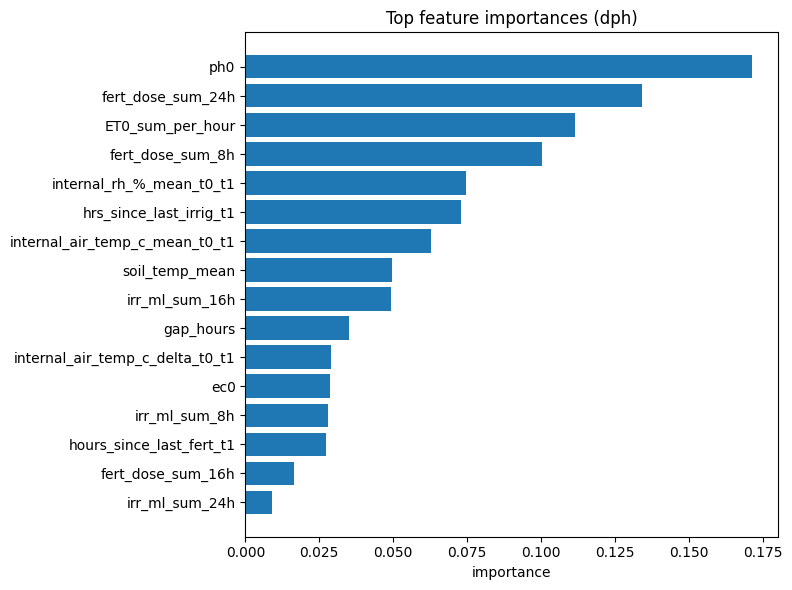

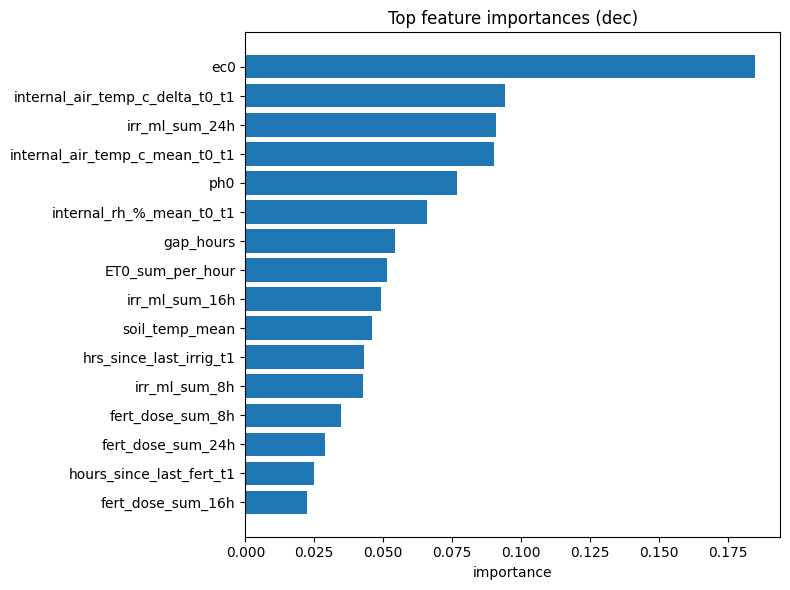

In [20]:
# Feature importance (display only) for the current feature sets.

# Fit full-data models to report importances (not used for walk-forward evaluation).
ph_rf = xgb.XGBRegressor(**xgb_params_ph)
ec_rf = xgb.XGBRegressor(**xgb_params_ec)
ph_rf.fit(X_all_ph, y_dph)
ec_rf.fit(X_all_ec, y_dec)


for tgt_name, est, cols in [
    ('dph', ph_rf, feature_cols_ph),
    ('dec', ec_rf, feature_cols_ec),
]:
    # Plot top features to keep interpretation focused.
    imp = pd.Series(est.feature_importances_, index=cols).sort_values(ascending=False)
    top = imp.head(min(25, len(imp)))
    plt.figure(figsize=(8,6))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.title(f'Top feature importances ({tgt_name})')
    plt.xlabel('importance')
    plt.tight_layout()
    plt.show()


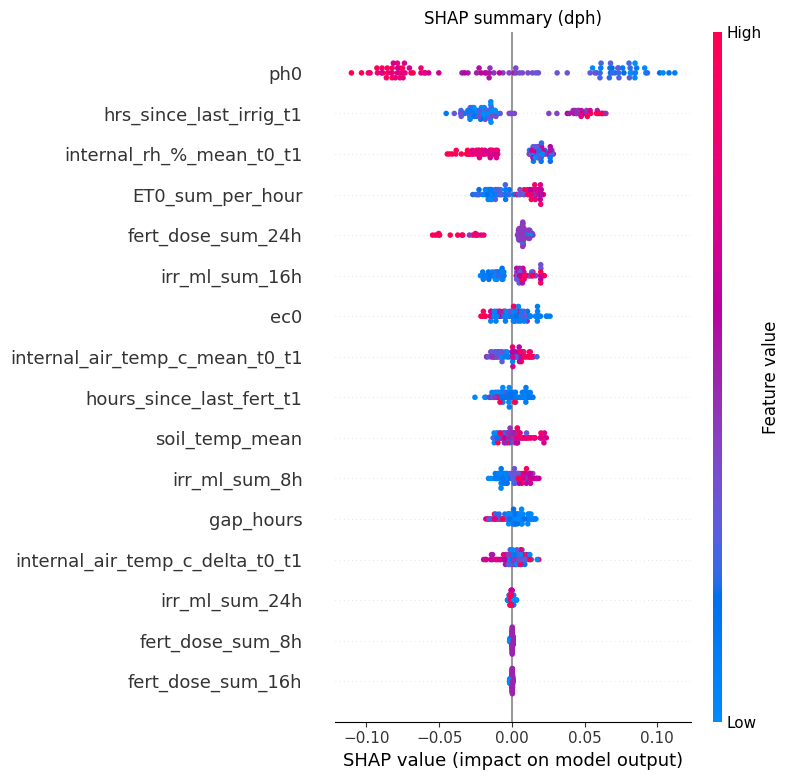

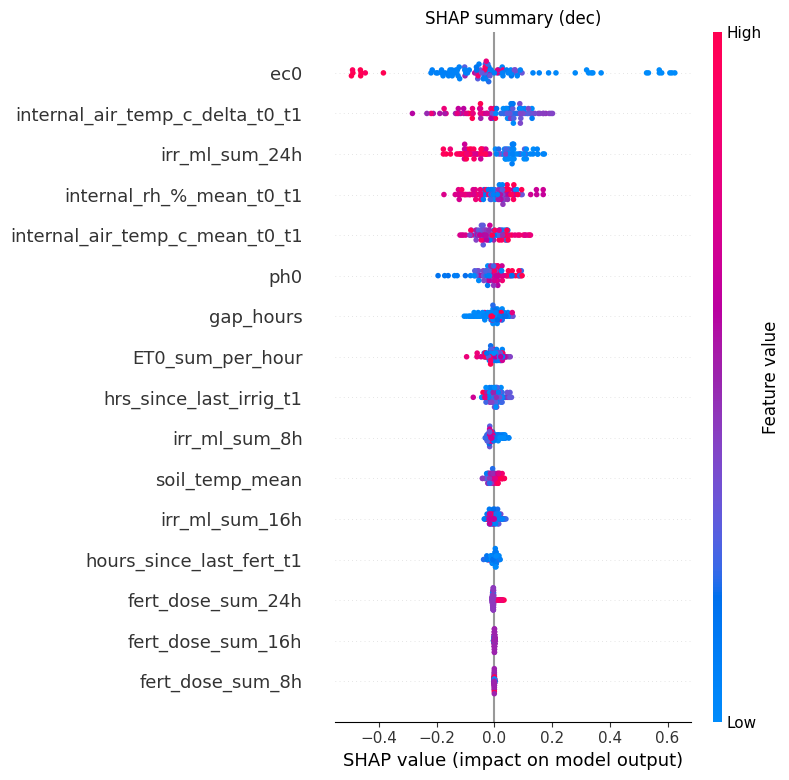

In [21]:
# SHAP summary plots (if shap is installed).
try:
    import shap
except ImportError as e:
    raise ImportError('shap is not installed in this environment. Install with: pip install shap') from e


# Train final models once (same as used in feature importances).
ph_final = xgb.XGBRegressor(**xgb_params_ph)
ec_final = xgb.XGBRegressor(**xgb_params_ec)
ph_final.fit(X_all_ph, y_dph)
ec_final.fit(X_all_ec, y_dec)


# Use a sample to keep runtime reasonable.
X_sample_ph = X_all_ph.sample(n=min(300, len(X_all_ph)), random_state=42)
X_sample_ec = X_all_ec.sample(n=min(300, len(X_all_ec)), random_state=42)


for tgt_name, est, X_sample in [
    ('dph', ph_final, X_sample_ph),
    ('dec', ec_final, X_sample_ec),
]:
    # TreeExplainer is fast for tree-based models and works well for XGBoost.
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_sample)
    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f'SHAP summary ({tgt_name})')
    plt.tight_layout()
    plt.show()


In [22]:
# Save prediction outputs for later analysis.
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(PROCESSED / 'rf_rootzone_model_predictions.csv')
print('Saved', PROCESSED / 'rf_rootzone_model_predictions.csv')

# Save a compact error table for quick inspection.
pred_df[['ph_abs_error','ec_abs_error','ph_signed_error','ec_signed_error']].to_csv(PROCESSED / 'Rootzone_per_interval_errors.csv')
print('Saved', PROCESSED / 'Rootzone_per_interval_errors.csv')


Saved C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rf_rootzone_model_predictions.csv
Saved C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\Rootzone_per_interval_errors.csv
